## Data provenance and characteristics:
 
### When and from where it was collected:
Data was collected from the GitHub presented in moodle:  https://github.com/Jl-wei/APIA2022-French-user-reviews-classification-dataset

### Text genre(s) and language(s) it covers
The data is purely made up of reviews on the app store, all of it written in French.

### How it has been annotated
Each entry in the data set is annotated with four labels: "Rating", "User Experience", "Feature request" and "Bug Report"
It also includes the score given by the user in each individual review.


## Pre-processing


### Importing the data 


In [38]:
import random

import nltk
import pandas as pd

# Read the data from the file
data_garmin_df = pd.read_csv('data/Garmin_Connect.csv')
data_samsung_df = pd.read_csv('data/Samsung_Health.csv')
data_huawei_df = pd.read_csv('data/Huawei_Health.csv')

data = pd.concat([data_garmin_df, data_samsung_df, data_huawei_df], ignore_index=True)
#data.to_csv('data/concatenated_data.csv', sep='\t', encoding='utf-8')

print(data.head(10))
print("\n Number of rows: " + str(len(data)))


                                                data  score  rating  \
0  Contrairement aux idées reçues le traceur GPS ...      5       1   
1               Application très pratique et fiable.      5       1   
2                                   jadore ma montre      5       1   
3  Super application, je l'utilise synchronisé av...      5       1   
4                                            Super !      5       1   
5  Application très pratique et très simple d'uti...      3       1   
6  Suivis du sommeil cardio nombre de pas avec la...      5       1   
7                                  Sympa et précis !      5       1   
8                                     Très satisfait      5       1   
9  bonjour, le calendrier ne se synchronise plus....      2       0   

   bug_report  feature_request  user_experience  
0           0                0                1  
1           0                0                0  
2           0                0                0  
3           0     

### Relevant plots

<Axes: >

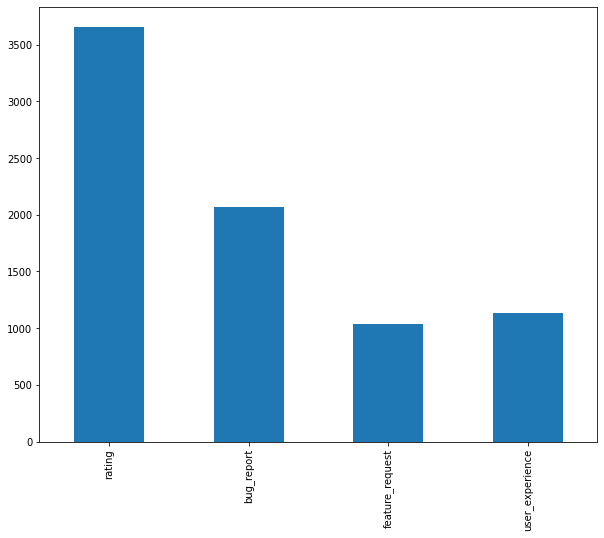

In [39]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

data_labels = data[["rating", "bug_report", "feature_request", "user_experience"]]

data_labels.sum(axis=0).plot.bar()

As we can see, the rating label is much more relevant than the other 3 labels, which causes unbalance and might mislead the results if not careful. Also, it seems that there are cases where more than 1 label can be applied. This makes it a multilabel problem:

![Types of classification problems (https://towardsdatascience.com/multilabel-text-classification-done-right-using-scikit-learn-and-stacked-generalization-f5df2defc3b5#6de1)](./data/Types_of_classification_problems.png "Types of classification problems")

To try to make this problem a binary one, one must make it so that the classification only hits one of the many label columns. That can be achieved by making all possible combinations columns in their own right. Or we can make it into a multiclass one by joining every label as a string in a new column "tags" and try to predict it.

                                                data  score  rating  \
0  Contrairement aux idées reçues le traceur GPS ...      5       1   
1               Application très pratique et fiable.      5       1   
2                                   jadore ma montre      5       1   
3  Super application, je l'utilise synchronisé av...      5       1   
4                                            Super !      5       1   

   bug_report  feature_request  user_experience                       tags  
0           0                0                1  [rating, user_experience]  
1           0                0                0                   [rating]  
2           0                0                0                   [rating]  
3           0                0                1  [rating, user_experience]  
4           0                0                0                   [rating]  


<Axes: >

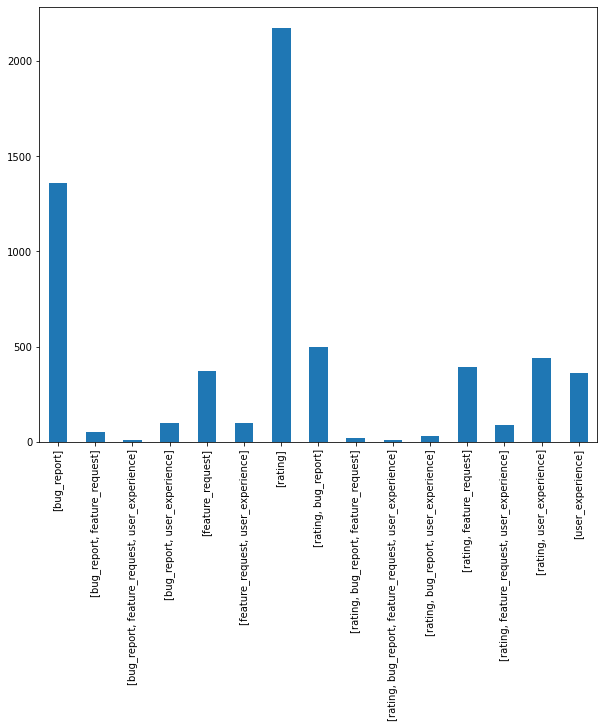

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

#data.insert(2, "Tags", [' ' for _ in range(len(data.index))], True)

tags = []

for index, row in data.iterrows():
    str_tag = ""
    if row["rating"] == 1:
        str_tag += "rating,"
    if row["bug_report"] == 1:
        str_tag += "bug_report,"
    if row["feature_request"] == 1:
        str_tag += "feature_request,"
    if row["user_experience"] == 1:
        str_tag += "user_experience,"

    list_tag = str_tag[0:-1].split(',')

    tags.append(list_tag)

#print(tags)´

data = data.assign(tags=tags)


mlb = MultiLabelBinarizer()

tags1 = mlb.fit_transform(data["tags"])

print(data.head())

data["tags"].value_counts().sort_index().plot.bar(x="Tag Distribution of All Observations", y="Number of observations")


### Tokenization and removal of stopwords

*Tokenization* is the process of splitting an input text into tokens (words or other relevant elements, such as punctuation, empty strings). We will use the result as a basis to predict a label.


In [41]:
from nltk.tokenize import word_tokenize #principal tokenization class from nltk API
from nltk.stem import SnowballStemmer #Stemming method
import re #regex library
nltk.download('punkt')

corpus = []

for index, row in data.iterrows():
    review = re.sub('\*', '', row["data"]) # get data, substitute asterisks for empty string, put into review
    review = re.sub('[^a-zA-Z]', ' ', review) # from review, remove all non-alphabetic characters
    review = re.sub('[^\w\s]', '', review) # remove punctuation from review
    review = ' '.join([SnowballStemmer('french').stem(w) for w in word_tokenize(review.lower(), language='french')]) # apply stemming
    corpus.append(review)

#print(corpus)

data = data.assign(token=corpus)

print(data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                data  \
0  Contrairement aux idées reçues le traceur GPS ...   
1               Application très pratique et fiable.   
2                                   jadore ma montre   
3  Super application, je l'utilise synchronisé av...   
4                                            Super !   

                                               token  score  rating  \
0  contrair aux id e re ue le traceur gp est tr s...      5       1   
1                      appliqu tr s pratiqu et fiabl      5       1   
2                                     jador ma montr      5       1   
3  sup appliqu je l utilis synchron avec ma fenix...      5       1   
4                                                sup      5       1   

   bug_report  feature_request  user_experience                       tags  
0           0                0                1  [rating, user_experience]  
1           0                0                0                   [rating]  
2    

### Separation between train and test datasets
Separate in adequate proportions to avoid the overfitting of the modules the data between features and targets. In this case there will be 2 different separations, one for the original multilabel problem and another for the mold into just a multiclass problem. To ensure a more even tag distribution, we must use the *stratify* hyper-parameter

In [42]:
from sklearn.model_selection import train_test_split

#features = ['token', 'score']

#X = data.loc[:,features] #select from data the features

X_train_mc, X_mc, y_train_mc, y_mc = train_test_split(
    data["token"], tags1, train_size=0.7, stratify=tags1, random_state=random.randint(0,100)
)

X_val_mc, X_test_mc, y_val_mc, y_test_mc = train_test_split(
    X_mc, y_mc, train_size=0.5, stratify=y_mc, random_state=random.randint(0,100)
)
"""
X_train_ml, X_ml, y_train_ml, y_ml = train_test_split(
    X, data_labels, train_size=0.7, stratify=data_labels, random_state=random.randint(0,100)
)

X_val_ml, X_test_ml, y_val_ml, y_test_ml = train_test_split(
    X_ml, y_ml, train_size=0.5, stratify=y_ml, random_state=random.randint(0,100)
)
"""
#print(X_train_mc)
#print(y_train_mc)
#print(X_train_ml)
#print(y_train_ml)

print(f'train: {len(X_train_mc)} ({len(X_train_mc)/len(data):.0%})\n'
      f'val: {len(X_val_mc)} ({len(X_val_mc)/len(data):.0%})\n'
      f'test: {len(X_test_mc)} ({len(X_test_mc)/len(data):.0%})')

train: 4200 (70%)
val: 900 (15%)
test: 900 (15%)


### Modeling

#### Importations and other preparations

In [43]:
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
#from skmultilearn.adapt import *

As we are using many models to compare the results, we can create a wrapper class so that we can use the pipeline to streamline the evocations needed.

In [44]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=RandomForestClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.

        Parameters
        ----------
        estimator: sklearn object, the classifier
        """
        self.estimator = estimator

    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

#### Pipeline (we might need to remove english stopwords as well)

In [45]:
from nltk.corpus import stopwords
nltk.download('stopwords')

final_stopwords_list = stopwords.words('english') + stopwords.words('french')
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                   max_features=200000,
                                   min_df=0.2,
                                   stop_words=final_stopwords_list,
                                   use_idf=True)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', ClfSwitcher())
])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Estimator grid and models to map

In [46]:
grid = ParameterGrid({
    'clf__estimator': [
        MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=random.randint(0,100), multi_class='multinomial', verbose=1), n_jobs=-1),
        MultiOutputClassifier(SGDClassifier(class_weight='balanced',tol=1e-4, verbose=1,random_state=random.randint(0,100), loss='modified_huber', early_stopping=True, warm_start=True, average=True), n_jobs=-1),
        MultiOutputClassifier(LinearSVC(dual=False, class_weight='balanced', random_state=random.randint(0,100), verbose=1), n_jobs=-1),
        KNeighborsClassifier(p=2,n_jobs=-1),
        RandomForestClassifier(class_weight='balanced', random_state=random.randint(0,100), n_jobs=-1, warm_start=True, verbose=1),
        MultiOutputClassifier(XGBClassifier(scale_pos_weight=(1-y_train_mc.mean())/y_train_mc.mean(), random_state=random.randint(0,100), n_jobs=-1), n_jobs = -1),
        MultiOutputClassifier(LGBMClassifier(is_unbalance=True, random_state=random.randint(0,100)), n_jobs=-1),
        MultiOutputClassifier(Perceptron(class_weight='balanced',random_state=random.randint(0,100), n_jobs = -1, tol=1e-4, verbose=1, early_stopping=True))
    ],
    'tfidf__ngram_range': [(1,2), (1,4)]
})

models = [
    'logreg1', 'logreg2', 'sgd1', 'sgd2', 'svm1', 'svm2', 'knn1', 'knn2', 'rf1', 'rf2',
    'xgb1', 'xgb2', 'lgbm1', 'lgbm2', "perc1", "perc2"
]

#models1 = ['brknnA1', 'brknnA2', 'brknnB1', 'brknnB2']
#grid1 = ParameterGrid({'clf__estimator':[BRkNNaClassifier(), BRkNNbClassifier()], 'k': range(1,3)})
#models2 = ['mlknn1', 'mlknn2', 'mlnkk3', 'mlknn4', 'mlknn5', 'mlknn6']
#grid2 = ParameterGrid({'clf__estimator': [MLkNN()], 'k': range(1,3), 's': [0.5, 0.7, 1.0]})
#models3 = ['mltSVM1','mltSVM2','mltSVM3','mltSVM4','mltSVM5']
#grid3 = ParameterGrid({'clf__estimator': [MLTSVM()], 'c_k': [2**i for i in range(-5, 5, 2)]})

#### Predictions and scores

In [47]:
from sklearn.metrics import precision_recall_fscore_support

scores = pd.DataFrame()

def score(y_true, y_pred, index):
    """Calculate precision, recall, and f1 score"""

    metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
    return pd.DataFrame(performance, index=[index])

for model, params in tqdm(zip(models, grid), total=len(models)):
    pipeline.set_params(**params)
    pipeline.fit(X_train_mc, y_train_mc)
    y_pred = pipeline.predict(X_val_mc)
    machine_learning = score(y_val_mc, y_pred, model)
    scores = pd.concat([scores, machine_learning])
"""
for model, params in tqdm(zip(models1, grid1), total=len(models1)):
    pipeline.set_params(**params)
    pipeline.fit(X_train_ml, y_train_ml)
    y_pred = pipeline.predict(X_val_ml)
    machine_learning = score(y_val_ml, y_pred, model)
    scores = pd.concat([scores, machine_learning])

for model, params in tqdm(zip(models2, grid2), total=len(models2)):
    pipeline.set_params(**params)
    pipeline.fit(X_train_ml, y_train_ml)
    y_pred = pipeline.predict(X_val_ml)
    machine_learning = score(y_val_ml, y_pred, model)
    scores = pd.concat([scores, machine_learning])

for model, params in tqdm(zip(models3, grid3), total=len(models3)):
    pipeline.set_params(**params)
    pipeline.fit(X_train_ml, y_train_ml)
    y_pred = pipeline.predict(X_val_ml)
    machine_learning = score(y_val_ml, y_pred, model)
    scores = pd.concat([scores, machine_learning])
"""

print(scores)

 12%|█▎        | 2/16 [00:00<00:04,  3.28it/s]C:\Users\afons\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 19%|█▉        | 3/16 [00:00<00:03,  4.00it/s]C:\Users\afons\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 38%|███▊      | 6/16 [00:01<00:03,  3.30it/s]C:\Users\afons\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

-- Epoch 1
Norm: 0.48, NNZs: 1, Bias: -0.005347, T: 3780, Avg. loss: 0.079358
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 1, Bias: 0.004240, T: 7560, Avg. loss: 0.075612
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.68, NNZs: 1, Bias: -0.006581, T: 11340, Avg. loss: 0.082080
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 1, Bias: 0.005537, T: 15120, Avg. loss: 0.079243
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.73, NNZs: 1, Bias: -0.006676, T: 18900, Avg. loss: 0.079386
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.23, NNZs: 1, Bias: -0.000032, T: 22680, Avg. loss: 0.080492
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.47, NNZs: 1, Bias: -0.002792, T: 3780, Avg. loss: 0.157875
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.42, NNZs: 1, Bias: -0.023728, T: 7560, Avg. loss: 0.167927
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.91, NNZs: 1, Bias: -0.001861, 

100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

-- Epoch 1
Norm: 0.48, NNZs: 1, Bias: -0.005347, T: 3780, Avg. loss: 0.079358
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 1, Bias: 0.004240, T: 7560, Avg. loss: 0.075612
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.68, NNZs: 1, Bias: -0.006581, T: 11340, Avg. loss: 0.082080
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 1, Bias: 0.005537, T: 15120, Avg. loss: 0.079243
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.73, NNZs: 1, Bias: -0.006676, T: 18900, Avg. loss: 0.079386
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.23, NNZs: 1, Bias: -0.000032, T: 22680, Avg. loss: 0.080492
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.47, NNZs: 1, Bias: -0.002792, T: 3780, Avg. loss: 0.157875
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.42, NNZs: 1, Bias: -0.023728, T: 7560, Avg. loss: 0.167927
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.91, NNZs: 1, Bias: -0.001861, 

### Plotting the results

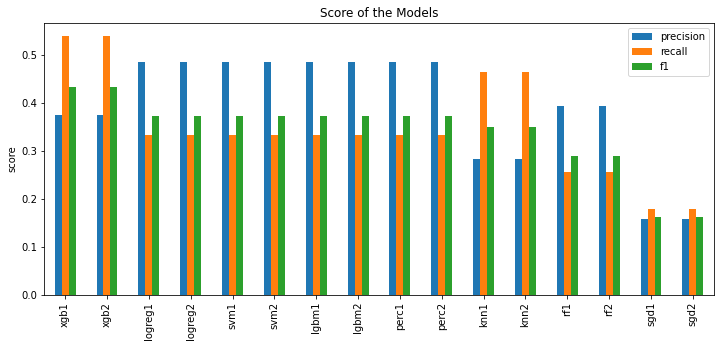

In [48]:
def plot(scores):
    """Plot scores of the models in a bar-plot based on f1 score"""

    scores.sort_values('f1', ascending=False).plot(
        kind='bar',
        figsize=(12,5),
        title='Score of the Models',
        ylabel='score'
    )
    plt.ylim(bottom=0)
    plt.show()

plot(scores)

The results are, for the most part, off-putting at best. The main reason lies on the fact that the dataset is unbalanced, with most of the entries either pointing towards a rating label, a bug report one or a combination of both. We can take into consideration that the centralization of all label columns into a single one expressing the different combinations may be a source of error as well, because it transformed into a 15 label classification problem with only 6000 entries. But, because of time constraints, perceived complexity and most sources pointing to this approach as the standard, other ways were not explored.

In [49]:
print(data["tags"].value_counts())

[rating]                                                  2176
[bug_report]                                              1360
[rating, bug_report]                                       496
[rating, user_experience]                                  442
[rating, feature_request]                                  392
[feature_request]                                          374
[user_experience]                                          360
[feature_request, user_experience]                         101
[bug_report, user_experience]                               97
[rating, feature_request, user_experience]                  88
[bug_report, feature_request]                               49
[rating, bug_report, user_experience]                       29
[rating, bug_report, feature_request]                       22
[bug_report, feature_request, user_experience]               7
[rating, bug_report, feature_request, user_experience]       7
Name: tags, dtype: int64


Otherwise, as the main language at work here is french, we do not have enough knowledge of which n-gram range is the most effective. One other thing to point out is that we were unable to incorporate the score as a feature of this dataset (only the text), which is a column we believe to be crucial in some cases to distinguish the review labels.
For those reasons, we believe that a neural network approach is the most adequate to deal with this kind of problem, as that would solve some issues, but unfortunately cannot address all concerns.